In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import HTML

In [17]:
IMAGE_SIZE = 128
BATCH_SIZE = 64
CHANNELS = 3
EPOCHS = 50
DIRECTORY = "E:\PycharmProjects\MalariaCatcher"

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    f"{DIRECTORY}\cell_images",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 27558 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['Parasitized', 'Uninfected']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(64, 128, 128, 3)
[1 1 1 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1 1 0
 0 1 1 1 0 1 0 0 1 1 1 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0]


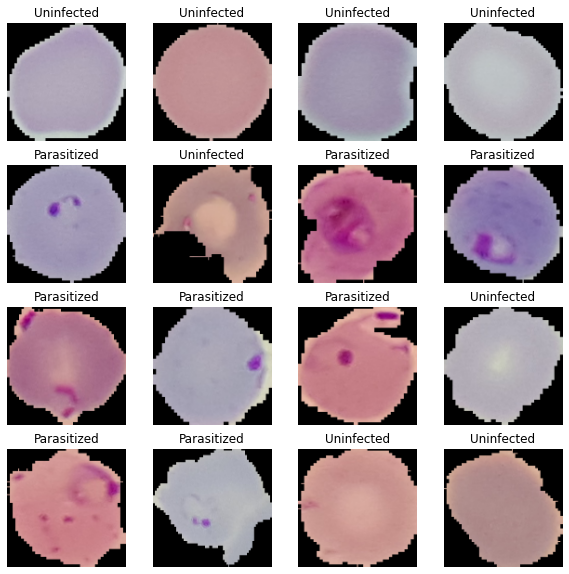

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
def partition_dataset_tf(dataset, train_ratio=0.8, test_ratio=0.1, shuffle=True, shuffle_size=10000):
    assert (train_ratio + test_ratio) <= 1 # If smaller 1, a validation set is also created.
    
    dataset_size = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_ratio * dataset_size)
    test_size = int(test_ratio * dataset_size)
    
    train_ds = dataset.take(train_size)
    test_ds = dataset.skip(train_size).take(test_size)
    val_ds = dataset.skip(train_size).skip(test_size)
    
    assert len(train_ds) + len(val_ds) + len(test_ds) == dataset_size
    
    return train_ds, val_ds, test_ds
        
    

In [8]:
train_ds, val_ds, test_ds = partition_dataset_tf(dataset)

In [9]:
print(f"train size:{len(train_ds)}, validation size:{len(val_ds)}, test size:{len(test_ds)}")

train size:344, validation size:44, test size:43


In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [12]:
augment_data = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation((-0.3,0.3))
])

In [13]:
train_ds = train_ds.map(
    lambda x, y: (augment_data(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_rescale,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 128, 128, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 126, 126, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (64, 63, 63, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (64, 61, 61, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (64, 30, 30, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (64, 28, 28, 64)         

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics='accuracy'
)

In [18]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/25
344/344 [==============================] - 35s 100ms/step - loss: 0.1238 - accuracy: 0.9600 - val_loss: 0.1089 - val_accuracy: 0.9680
Epoch 2/25
344/344 [==============================] - 34s 100ms/step - loss: 0.1218 - accuracy: 0.9592 - val_loss: 0.1278 - val_accuracy: 0.9609
Epoch 3/25
344/344 [==============================] - 35s 101ms/step - loss: 0.1196 - accuracy: 0.9603 - val_loss: 0.1087 - val_accuracy: 0.9659
Epoch 4/25
344/344 [==============================] - 34s 100ms/step - loss: 0.1157 - accuracy: 0.9608 - val_loss: 0.1078 - val_accuracy: 0.9645
Epoch 5/25
344/344 [==============================] - 35s 102ms/step - loss: 0.1163 - accuracy: 0.9605 - val_loss: 0.1120 - val_accuracy: 0.9624
Epoch 6/25
344/344 [==============================] - 35s 102ms/step - loss: 0.1119 - accuracy: 0.9621 - val_loss: 0.1092 - val_accuracy: 0.9645
Epoch 7/25
344/344 [==============================] - 34s 100ms/step - loss: 0.1118 - accuracy: 0.9617 - val_loss: 0.1068 - val_ac

In [ ]:
score = model.evaluate(test_ds)
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("Example Image")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    print("predicted label:",class_names[np.argmax(model.predict(images_batch)[0])])
    print(model.predict(images_batch)[0])

In [ ]:
def call_prediction(model, image):
    image_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    image_array = tf.expand_dims(image_array, 0)
    
    predictions = model.predict(image_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),3)
    return predicted_class, confidence
    

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = call_prediction(model, images[i].numpy())
        correct_class = class_names[labels[i]] 
        
        plt.title(f"Correct: {correct_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [28]:
#save as h5
model_version=max([int(i) for i in os.listdir(f"{DIRECTORY}/models") + [0]])+1
model.save(f"{DIRECTORY}/models/{model_version}.h5")

ValueError: invalid literal for int() with base 10: 'v1_e2.h5'

In [19]:
#save as standard
model.save(f"{DIRECTORY}/models/3.h5")
#model.save(f"{DIRECTORY}/models/v2_e{EPOCHS}")